In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('2. match(AGN w BZCAT5).csv')

In [5]:
df.columns

Index(['Entry number', 'Fermi name', 'Counterpart name', 'Bzcat5 name',
       'Optical Class', 'RA (J2000.0)', 'Dec (J2000.0)', 'Redshift',
       'SED Class', 'Log Î½Sync. Z corr. (Hz)', 'Probability Bayesian',
       'Reliability LR RG', 'Reliability LR XG', 'Significance',
       'Flux 1-100 GeV (ph/cm2/s)', 'Spectral Index', 'Spectral Type',
       'Power Law Index', 'Radio flux (mJy)', 'X Flux (erg cm-2 s-1)',
       'USNO Vmag', 'SDSS Vmag', 'Seq', 'Name', 'RAh', 'RAm', 'RAs', 'DE-',
       'DEd', 'DEm', 'DEs', 'GLON', 'GLAT', 'z', 'u_z', 'Rmag', 'Class', 'FR',
       'F143', 'FX', 'FF', 'aro', 'RA_deg', 'DEC_deg', 'Separation'],
      dtype='object')

In [8]:
target_classes = ['BL Lac', 'QSO RLoud flat radio sp.']

filtered_df = df[df['Class'].isin(target_classes)]

input_vector = filtered_df[['FR', 'Rmag', 'FX', 'z', 'Log Î½Sync. Z corr. (Hz)', 'Power Law Index']].values
output_vector = filtered_df['Class'].values

In [9]:
binary_labels = (output_vector == "BL Lac").astype(int)

In [10]:
input_tensor = torch.from_numpy(input_vector).to(dtype=torch.float32)
output_tensor = torch.from_numpy(binary_labels).to(dtype=torch.float32)

full_dataset = TensorDataset(input_tensor, output_tensor)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [20]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
epochs = 300
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/300, Loss: 0.5640
Epoch 11/300, Loss: 0.3248
Epoch 21/300, Loss: 0.2871
Epoch 31/300, Loss: 0.2533
Epoch 41/300, Loss: 0.2054
Epoch 51/300, Loss: 0.3382
Epoch 61/300, Loss: 0.4440
Epoch 71/300, Loss: 0.1467
Epoch 81/300, Loss: 0.3008
Epoch 91/300, Loss: 0.0755
Epoch 101/300, Loss: 0.2572
Epoch 111/300, Loss: 0.1444
Epoch 121/300, Loss: 0.4203
Epoch 131/300, Loss: 0.4242
Epoch 141/300, Loss: 0.1396
Epoch 151/300, Loss: 0.3777
Epoch 161/300, Loss: 0.2588
Epoch 171/300, Loss: 0.1613
Epoch 181/300, Loss: 0.1315
Epoch 191/300, Loss: 0.2207
Epoch 201/300, Loss: 0.1931
Epoch 211/300, Loss: 0.2179
Epoch 221/300, Loss: 0.0690
Epoch 231/300, Loss: 0.1587
Epoch 241/300, Loss: 0.1573
Epoch 251/300, Loss: 0.3306
Epoch 261/300, Loss: 0.1842
Epoch 271/300, Loss: 0.2655
Epoch 281/300, Loss: 0.2507
Epoch 291/300, Loss: 0.1990


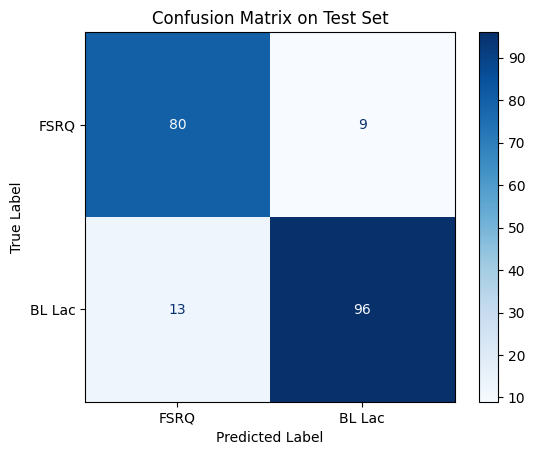

In [22]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predictions = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

labels = ["FSRQ", "BL Lac"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
